In [440]:
import pandas as pd
#先週使ったワインのデータのインポート
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None) 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values #2列目以降全部をXに入れ、1列目をyに入れる
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) #訓練データ70％、テストデータ30％
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train) #訓練データとテストデータを標準化
X_test_std = sc.transform(X_test)

####共分散行列(step2)の計算に入る(スライドに戻ります)###

固有値の計算は大変だけど、numpyのlinalg.eigが固有値と固有ベクトルを出してくれる

In [441]:
import numpy as np
cov_mat = np.cov(X_train_std.T) #訓練データのそれぞれの特徴量に対し、共分散を計算する(結果は13*13共分散行列,13要素のリスト１３本のリスト)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat) #linalg.eigが固有値と固有ベクトルを計算(大きい順に並ぶ)
print('\nEigenvalues \n%s' % eigen_vals)
#print('\ncov_mat\n%s' % cov_mat)
#print('\nEigenvecters \n%s' % eigen_vecs)


Eigenvalues 
[ 4.8923  2.4664  1.4281  1.0123  0.8491  0.6018  0.5225  0.0841  0.3305
  0.296   0.1683  0.2143  0.24  ]


上の通り、固有値のリストが出力されてる

固有ベクトルは１３次元ベクトルのリストになってる(最下コメントアウトを外すと表示)

(注意):np.linalg.eigは複素ベクトルを返すことがある。そのため必ず実数値を返す、エルミート行列を対象にしたnp.linalg.eighを用いるとより安定する。

固有値が大きいほど分散が大きくなるため、固有値が大きい順に削減後の次元数個分固有ベクトルを取ってきたい。

続いて、分散説明率を調べる。(固有値/全ての固有値の和)

こうすることである固有値がどれくらい全体の分散に貢献してるかがわかる。

In [442]:
tot = sum(eigen_vals) #全固有値の和
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)] #分散説明率を降順に並べる
cum_var_exp = np.cumsum(var_exp) #cumsum:cumulative sum 累積和、一項ずつ和が増えていくリスト。比率の和なので最大は１。
print('\ncum_var_exp \n%s' % cum_var_exp)


cum_var_exp 
[ 0.3733  0.5615  0.6705  0.7477  0.8125  0.8584  0.8983  0.9235  0.9461
  0.9644  0.9807  0.9936  1.    ]


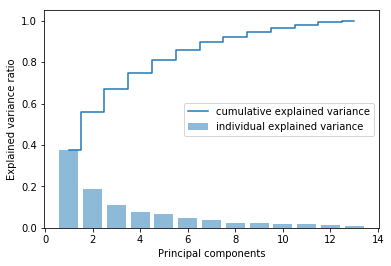

In [443]:
import matplotlib.pyplot as plt
#棒グラフの描画(それぞれの分散説明率)
plt.bar(range(1,14), var_exp, alpha=0.5, align='center',label='individual explained variance')
#階段グラフの描画(分散説明率の累積和)
plt.step(range(1,14), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

結果を見ると最初の主成分で40%、次で20%、合計60%の分散を表現できてる。

４章で学んだランダムフォレストによる大事な特徴の選別と似たような結果になる。

最大の違いは、教師ありか教師なしか。教師なしで同じような結果を導くことが可能。

残りのタスクは次の通り：

4,固有値が大きい順にｋ個固有ベクトルを選ぶ

5,選んだｋ個の固有ベクトルで射影行列Wを作る(d次元空間からk次元空間へ)

6,d次元入力データｘにWを作用させてk次元に落とす

In [444]:
#固有値と固有ベクトルのペアのリストを作り降順に並べる
eigen_pairs =[(np.abs(eigen_vals[i]),eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

#変換行列Wを作成。描画のため上位二本のペアを選ぶ。実際にどれくらいの次元を残すかは計算コストと分類能力のトレードオフを見ながら決定する。
#hstackなので横に並び替えた結果上位二本の固有ベクトル配列を連結している
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n',w)

Matrix W:
 [[ 0.1467  0.5042]
 [-0.2422  0.2422]
 [-0.0299  0.287 ]
 [-0.2552 -0.0647]
 [ 0.1208  0.23  ]
 [ 0.3893  0.0936]
 [ 0.4233  0.0109]
 [-0.3063  0.0187]
 [ 0.3057  0.0304]
 [-0.0987  0.5453]
 [ 0.3003 -0.2792]
 [ 0.3682 -0.1744]
 [ 0.2926  0.3632]]


もともと１３次元の訓練データxに変換行列Wを作用させてやると、以下のように二次元のデータに変換される。

In [445]:
X_train_std[0].dot(w) #一次元では内積、二次元以上では行列積

array([ 2.5989,  0.0048])

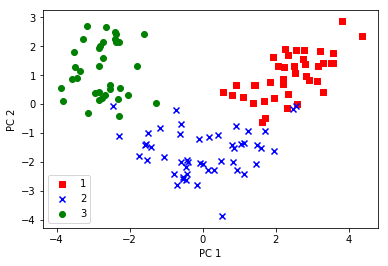

In [446]:
X_train_pca = X_train_std.dot(w) #全訓練データにWを掛ける

#色とマーカーの定義
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

#点のプロット
for l, c, m in zip(np.unique(y_train), colors, markers):#同時に複数のリストから値を一つずつ取り出す（長さは一番短いものに合わせる）
    plt.scatter(X_train_pca[y_train==l, 0],X_train_pca[y_train==l, 1], c=c, label=l, marker=m)
    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

分散説明率４割のpc1では、２割のPC2よりよく値が広がっている。

直観的に線型分離しやすそうになってる。

今まで長々とやってきたが、scikit-learnにすでにPCAは入っている。

以下のコードで実際にクラス分類するまでやる

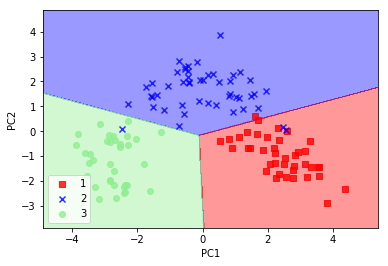

In [447]:
from matplotlib.colors import ListedColormap

########いつもの決定領域塗り分けする関数#########
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
       # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                       alpha=0.8, c=cmap(idx),
                       marker=markers[idx], label=cl)       
#########################################################

from sklearn.linear_model import LogisticRegression #ロジスティック回帰を分類器に使用
from sklearn.decomposition import PCA #PCAをインポート
pca = PCA(n_components=2) #二次元に落とすよう指定
lr = LogisticRegression() #ロジスティック回帰するオブジェクトlr
X_train_pca = pca.fit_transform(X_train_std) #訓練データをPCAを用いてフィットさせる(fitとtransformを同時に行う)
X_test_pca = pca.transform(X_test_std) #テストデータにも同様の操作をする(上でfitしているのでtransformだけ)
lr.fit(X_train_pca, y_train) #ロジスティック回帰を実行
plot_decision_regions(X_train_pca, y_train, classifier=lr) #決定領域塗り分け関数を実行
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

上の自作PCAと比較すると、上下反転している。(固有ベクトルに負値を許しているため。普通は長さ１の単位ベクトルとする)

続いてテストデータを投入し、成果を試す。

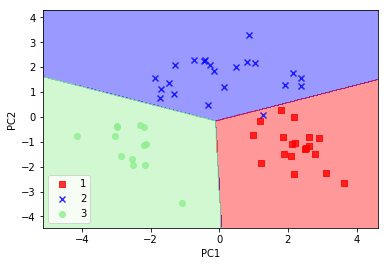

In [448]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

二次元だけしか特徴量を使っていないのに、綺麗に分類出来ていることからPCAが強力な手法であることがわかる。

PCAを実行する時の引数にNONEを指定すると、次元削減される代わりに、全ての主成分が大きい順に並べた状態になる。

以下で分類寄与率を見てみる

In [449]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([ 0.3733,  0.1882,  0.109 ,  0.0772,  0.0648,  0.0459,  0.0399,
        0.0252,  0.0226,  0.0183,  0.0164,  0.0128,  0.0064])

####続いてLDAの説明に入る####(スライドに戻ります)

まず、計算に使うクラス内の平均値を出していく

In [450]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4): #クラスの数は1~3の３つ
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0)) #クラスごとに平均値を計算し、mean_vecsに追加していく
    print('MV %s: %s \n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017] 

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016] 

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912] 



続いてS_W(クラスごとの分散行列S_iの和)を計算していく

In [451]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label,mv in zip(range(1,4), mean_vecs): #ラベルとして1~4の数字と各クラスの特徴の平均を一つずつ取り出していく
    class_scatter = np.zeros((d, d)) #d×d次元のゼロ行列を生成する
    for row in X_train[y_train == label]: #クラスごとに特徴の値を一つずつ取ってくる
        row, mv = row.reshape(d, 1), mv.reshape(d, 1) #ある特徴の値とその平均値をそれぞれd次元の列ベクトルにする
        class_scatter += (row-mv).dot((row-mv).T) #特徴の値と平均の差の二乗を足していく(S_iの計算)
    S_W += class_scatter #(S_iを足し上げてS_Wを計算している)

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [452]:
print('Class label distribution: %s' % np.bincount(y_train)[1:]) #それぞれの値の出現個数をカウントする


Class label distribution: [40 49 35]


上記結果を見てみるとラベルが一様に分布してるという上の行列を計算するときの仮定に反している。（でも大丈夫）

次は、スライドにあったS_iを正規化してS_Wを計算する方法で実行してみる(結局共分散行列を計算している)

In [453]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label,mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T) #上との違い。結局S_iを計算する段階で共分散を計算している
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


続いて、クラス間の分散行列S_Bの計算を行う。

In [454]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13 # number of features
S_B = np.zeros((d, d))
for i,mean_vec in enumerate(mean_vecs):
    n = X_train[y_train==i+1, :].shape[0] #nにそれぞれのクラスのx_trainの行のサイズ(それぞれのクラスに分類されるサンプル数)をnに入れる(shape[0]は行,shape[1]は列)
    mean_vec = mean_vec.reshape(d, 1)  #平均ベクトルをd次元列ベクトルに直す
    mean_overall = mean_overall.reshape(d, 1) #クラス全体の平均ベクトルをd次元列ベクトルに直す
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T) #クラスの平均と全体の平均との分散の和
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


次はPCAのように固有値問題を解く。(S_W^-1)S_Bの固有値と固有ベクトルを求める。

In [455]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B)) #S_Wの逆行列とS_Bの積を取り、それの固有値と固有ベクトルを求める
#PCAの時と同様、固有値と固有ベクトルのペアを作り、固有値の大きい順に並べる
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs,key=lambda k: k[0], reverse=True)

print('Eigenvalues in decreasing order:\n')

for eigen_val in eigen_pairs:
    print(eigen_val[0])


Eigenvalues in decreasing order:

452.721581245
156.43636122
8.84215767779e-14
3.85964077506e-14
3.02745061394e-14
2.84217094304e-14
1.93779970869e-14
1.74141815759e-14
1.74141815759e-14
1.14744129017e-14
8.21588388107e-15
4.43428864204e-15
4.43428864204e-15


スライドで言及していた通り、１３次元あるうち２つしか固有値が非ゼロにならない。（微妙に値が出てるのは浮動小数点の計算の端数）

以下にPCAの分散説明率と同様、どれくらい情報を判別しているかの度合いdiscriminabilityを示す。(対象の固有値/全体の固有値の和)

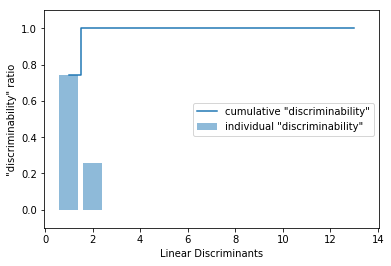

In [456]:
tot = sum(eigen_vals.real) #固有値の総和
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)] #大きい順に固有値/固有値の総和を計算
cum_discr = np.cumsum(discr) #累積和のリストを生成
#棒グラフと階段グラフを描画
plt.bar(range(1, 14), discr, alpha=0.5, align='center',label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

上で述べた通り、上位２つの固有値しか判別に貢献していないことがわかる。

この２つの固有ベクトルを用いてWを作る

In [457]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


WをXに適用して、Xの次元を削減する。

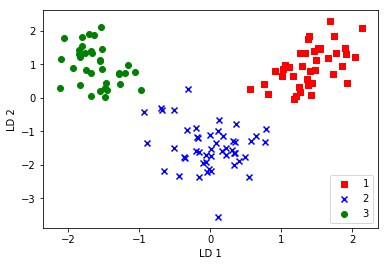

In [458]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0]*(-1),
    X_train_lda[y_train==l, 1]*(-1),
    c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.show()


ぱっと見完全に線型分離できてる気がする。

例によって決定領域を塗り分けることによって確かめてみる。

PCA同様scikit-learnにLDAは実装してある。

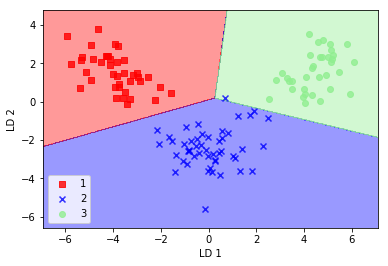

In [459]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis ##教科書のコードに使われるldaは古くなっている(警告が出る)
lda = LinearDiscriminantAnalysis(n_components=2) #削減した後の次元を２に設定
X_train_lda = lda.fit_transform(X_train_std, y_train) #訓練データにldaをフィットさせてトランスフォームする

lr = LogisticRegression() #PCA同様ロジスティック回帰を分類器として採用
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr) #PCAで定義した決定領域塗り分け関数を再利用
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

今度はテストデータに対して実行する。

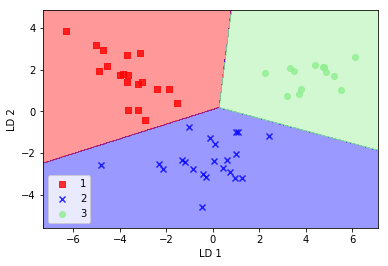

In [460]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

In [ ]:
ご覧の通り、LDAを用いるとたった二次元で１３次元データを綺麗に分類可能である。

次は３つめのkernel principal component analysis の説明である。（鍋谷さんの発表に続く）